Чтобы оптимизировать производственные расходы, металлургическому комбинату ООО «Так закаляем сталь» необходимо уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель машинного обучения, которая предскажет температуру стали.     
Целевой признак: конечная температура перед разливом в слябы.   
Метрика: MAE ≤ 6.8   

Описание этапа обработки.   
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн.
Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом.
Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы.
Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ.
Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом.
Затем его перемешивают и снова проводят измерения.
Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки.
Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

Описание данных
Данные состоят из файлов, полученных из разных источников:   
arc.csv — данные об электродах;    
bulk.csv — данные о подаче сыпучих материалов (объём);   
bulk_time.csv — данные о подаче сыпучих материалов (время);   
gas.csv — данные о продувке сплава газом;   
temp.csv — результаты измерения температуры;   
wire.csv — данные о проволочных материалах (объём);      
wire_time.csv — данные о проволочных материалах (время).    
Во всех файлах столбец key содержит номер партии.    
В файлах может быть несколько строк с одинаковым значением key:   
они соответствуют разным итерациям обработки.    



## Изучение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler

**данные об электродах**

In [2]:
try:
    data_arc = pd.read_csv('arc_new.csv')
except:
    print('unable to open the file arc')

In [3]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Значение key у нас повторяется, что говорит о разных итерациях обработки для достижения целевого химического состава и оптимальной температуры плавления.

In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Время начала и конца нагрева object, стоит перевести его в datetime

In [5]:
data_arc.duplicated().sum()

0

In [6]:
data_arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Дубликаты и пропуски отсутствуют

In [7]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


У реактивной мощности минимальное значение -715. Похоже на выброс. Надо почистить

In [8]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]
data_arc['Реактивная мощность'].describe()

count    14875.000000
mean         0.487115
std          0.197612
min          0.153777
25%          0.337190
50%          0.441665
75%          0.608223
max          1.270284
Name: Реактивная мощность, dtype: float64

Полная мощность складывается из активной мощности, совершающей полезную работу и реактивной мощности, расходуемой на создание магнитных полей. Активная энергия в нашем случае преобразуется в тепловую, а реактивная с выполнением полезной работы не связана, но необходима для создания электромагниного поля. Посмотрим на гистограммы активной и реактивной мощности.

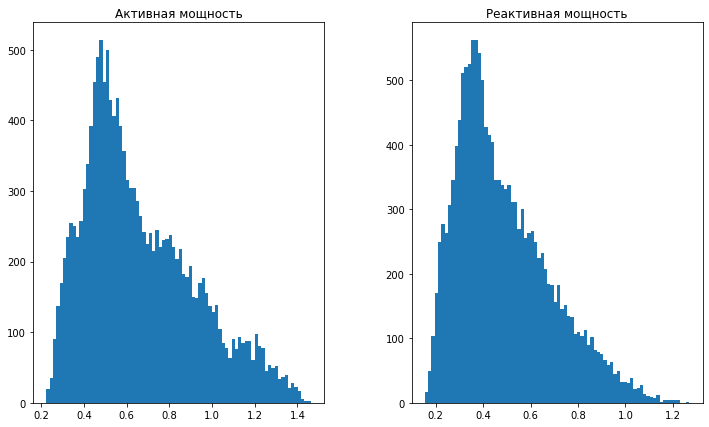

In [9]:
data_arc[['Активная мощность', 'Реактивная мощность']].hist(figsize=(12,7), grid=False, bins=80)
plt.show()

Распределение близко к нормальному, но справа есть хвостик

Посмотрю на корреляцию активной и реактивной мощности

In [10]:
data_arc['Активная мощность'].corr(data_arc['Реактивная мощность'])

0.9663734456187295

При таком высоком значении корреляции наша модель переобучится. Попробуем использовать для обучения полную мощность.

Думаю, нам нужен период между началом и концом нагрева в секундах

**данные о подаче сыпучих материалов (объём)**

In [11]:
try:
    data_bulk_v = pd.read_csv('bulk_new.csv')
except:
    print('unable to open the file bulk')

In [12]:
data_bulk_v.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [13]:
data_bulk_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [14]:
data_bulk_v.duplicated().sum()

0

In [15]:
data_bulk_v.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Очевидно что сыпучие материалы добавляют не всегда. Фактически во всех столбцах, кроме Bulk12, Bulk14 и Bulk15 сыпучие материалы добавляют реже, чем в половине случаев. Думаю, надо оставить только столбцы 12, 14 и 15, заполнить пропуски нулями и перевести тип данных в int. Посмотрим на распределение сыпучих материалов.

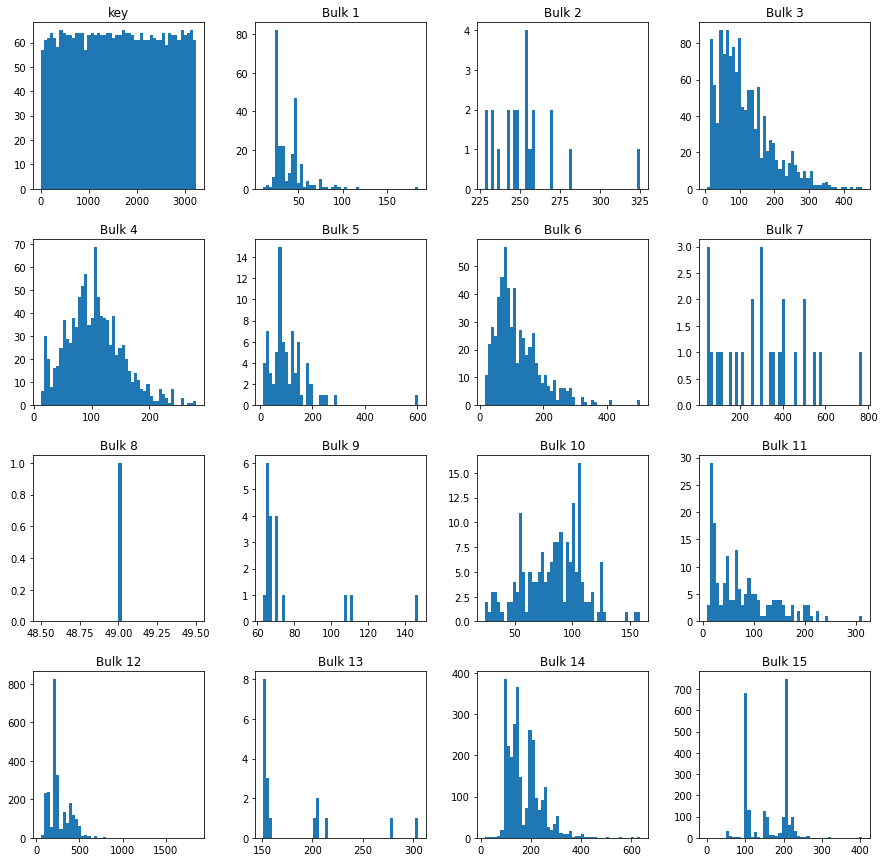

In [16]:
data_bulk_v.hist(figsize=(15,15), grid=False, bins=50)
plt.show()

 Более-менее похожее на нормальное распределение у 3, 4, 5, 6, 10 Bulk-ов. Остальные выглядят скорее как дискретные пики.

***данные о подаче сыпучих материалов (время)***

In [17]:
try:
    data_bulk_time = pd.read_csv('bulk_time_new.csv')
except:
    print('unable to open the file bulk_time')

In [18]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [19]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [20]:
data_bulk_time.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [21]:
data_bulk_v.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Похоже, мы имеем дело с идентичными пропусками. Значит можно будет объединить таблицы, а пропуски заменить нулями.

In [22]:
try:
    data_temp = pd.read_csv('temp_new.csv')
except:
    print('unable to open the file temp')

In [23]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [24]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [25]:
data_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [26]:
round(data_temp.isna().sum().sort_values(ascending=False)[0]/len(data_temp), 3)

0.189

большое количество пропусков, надо разбираться

Посмотрим на диаграмму размаха

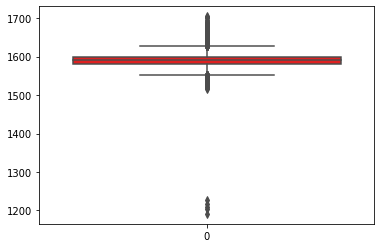

In [27]:
sns.boxplot(data=data_temp['Температура'], palette={'red'})
plt.show()

На диаграмме явно прослеживаются выбросы сильно ниже 1500 гр. Это могут быть как более легкоплавкие сплавы, так и реальные выбросы. Я бы убрала все, что ниже 1490 гр для чистоты эксперимента.

***данные о проволочных материалах (объём)***

In [28]:
try:
    data_wire_v = pd.read_csv('wire_new.csv')
except:
    print('unable to open the file wire') 

In [29]:
data_wire_v.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
data_wire_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [31]:
data_wire_v.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Только Wire 1 содержит менее 50% пропусков. Посмотрим на распределение 

array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'Wire 1'}>,
        <AxesSubplot:title={'center':'Wire 2'}>],
       [<AxesSubplot:title={'center':'Wire 3'}>,
        <AxesSubplot:title={'center':'Wire 4'}>,
        <AxesSubplot:title={'center':'Wire 5'}>],
       [<AxesSubplot:title={'center':'Wire 6'}>,
        <AxesSubplot:title={'center':'Wire 7'}>,
        <AxesSubplot:title={'center':'Wire 8'}>],
       [<AxesSubplot:title={'center':'Wire 9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

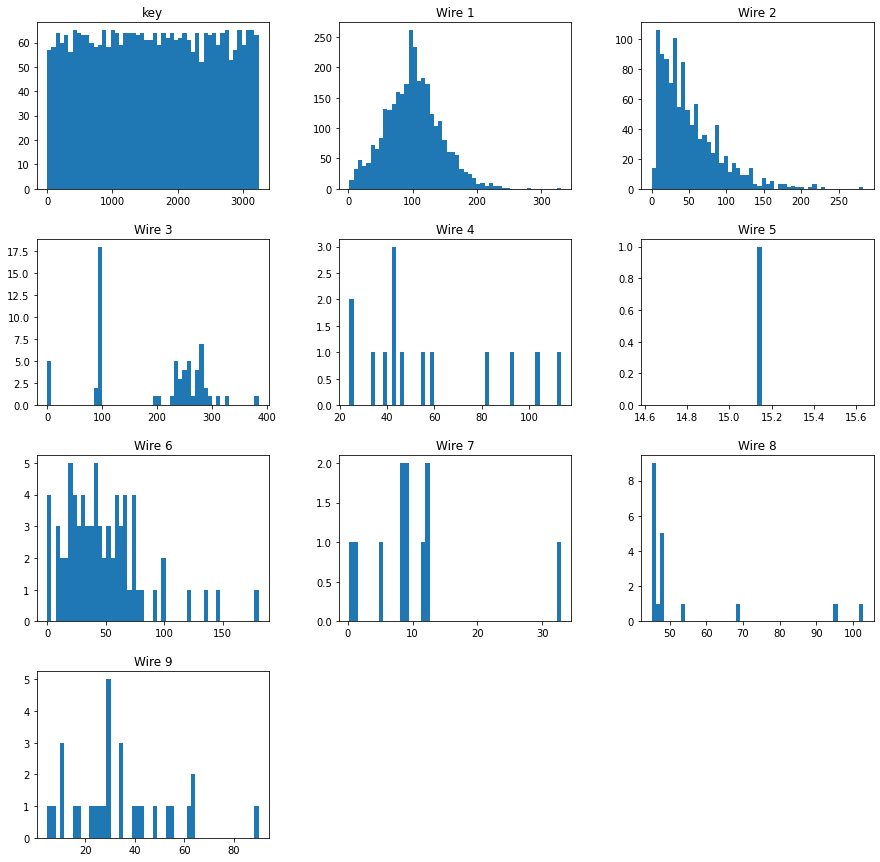

In [32]:
data_wire_v.hist(figsize=(15, 15), grid=False, bins=50)

Нормальное распределение у 1го и приблизительное у 2го и 6го Wire. В остальных - дискретные пики.

***данные о проволочных материалах (время)***

In [33]:
try:
    data_wire_time = pd.read_csv('wire_time_new.csv')
except:
    print('unable to open the file wire_time') 

In [34]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
data_wire_time.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [36]:
data_wire_v.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Та же история, что и с bulk. Пропуски в одинаковых местах у объёма и времени.

***данные о продувке сплава газом***

In [37]:
try:
    data_gas = pd.read_csv('gas_new.csv')
except:
    print('unable to open the file gas')

In [38]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [39]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


***Выводы:
С загрузкой всё ОК.   
Все названия столбцов надо привести к стандарту. Определиться, какие данные необходимо оставить, а от каких избавиться.  Перевести время в datetime.   
Есть пропуски.Нужно будет заменить их нулями. В данных с реактивной мощностью есть очевидный выброс. Он удален. После удаления выброса у активной и реактивной мощности распределение нормальное со смещением пика влево.    
Основная часть сыпучих присадок не имеет нормального распределения, а характеризуется дискретными пиками. Нормальное распределение у Bulk4, Bulk6. У Bulk3, Bulk5 нормальное со сдвигом пика влево.   
Похожая картина с проволокой. Только у 1, 2, 6 столбцов нормальное или близкое к норме распределение, у остальных - пики.   
В data_bulk_v b data_bulk_time пропуски совпадают, что наводит на мысль об объединении таблиц. Пропуски стоит заменить нулями. То же самое и у wire.   
Думаю убрать те присадки, у которых данные отсутствуют более чем в 50%.   
На диаграмме размаха температуры явно прослеживаются выбросы сильно ниже 1500 гр. Думаю, нужно удалить все, что ниже 1490 гр.***

План  
_1 Импорт билиотек   
_2 Загрузка данных   
_З Гистограммы, боксплоты   
_4 Приведение названий столбцов к стандарту   
_5 Избавиться от лишних данных     
_6 Заменить или удалить пропуски      
_7 Разобраться с выбросами   
_8 Где надо, изменить тип данных   
_9. Добавить необходимые столбцы    
_10. Сформировать новую таблицу, содержащую только необходимую информацию  
_11. Анализ свежесобранной таблицы   
_12. Разделение данных на тестовую и обучающую выборку   
_13. Подбор гиперпараметров   
_14. Обучение моделей   
_15. Выбор модели-победителя   
_16. Тестирование модели-победителя на предмет соответствия требованиям   
_17. Вывод
